# NLP Fundamentals in TensorFlow

NPL has the goal of deriving information out of natural language (could be sequences, text, or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3fda7db7-c027-2330-093c-2037f5656c1e)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/Romeo-5/helper_functions/main/python_functions.py

# Import series of helper functions for notebook
from python_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-08-18 22:29:35--  https://raw.githubusercontent.com/Romeo-5/helper_functions/main/python_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10131 (9.9K) [text/plain]
Saving to: ‘python_functions.py’

python_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2023-08-18 22:29:36 (137 MB/s) - ‘python_functions.py’ saved [10131/10131]



## Get a text dataset

The dataset we're going to be using is Kaggle's intorudction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

https://www.kaggle.com/competitions/nlp-getting-started



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-08-18 22:29:42--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-08-18 22:29:42 (108 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be with Python.

Another way is to use pandas to visualize straight away. Needs to fit within colab RAM.

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class are there?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
CW500: Dealing with disaster - http://t.co/jq9nJ6Gko3

---

Target: 0 (not real disaster)
Text:
The MF Life is a vocal and lyrical bomb. Saw her live this summer. AMAZING vocalist. RT @THEmale_madonna: Melanie Fiona is so slept on ??

---

Target: 0 (not real disaster)
Text:
I honestly wonder what it is that I had to do so wrong to lose everyone.

---

Target: 0 (not real disaster)
Text:
The feeling of lonelyness has sunk into me strange depressing feeling.

---

Target: 0 (not real disaster)
Text:
I have my final tomorrow ?????? . Ish is stressful  but I'll survive

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for val split
                                                                            random_state=42)

In [13]:
# Check the lengths of the splits
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things to do before building a model is to convert the text to numbers.

There are a few ways to do this:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vectors for each token (the size of the feature vectore can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (default is None)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want sequences to be?
                                    pad_to_max_tokens=True)

In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many wordss from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a fire in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3,  42,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/zevAn9kJzL http://t.co/UUZFs1L5Kt        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 646, 1084,  127,  436,    4,  218,    4, 2025, 1704,  689, 1130,
         257,    1,    1,    0]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make the embedding, you can use TensorFlow's embedding layer.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for examlpe, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )
embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Enugu Government to demolish illegal structures at International Conference Centre http://t.co/DaqszZuBUb        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00627104,  0.02385939, -0.03311064, ..., -0.03163338,
          0.00264813, -0.04297929],
        [ 0.00742579,  0.03681985, -0.02320966, ...,  0.04480802,
         -0.00642624, -0.03949664],
        [-0.04243907,  0.04805959, -0.00627989, ...,  0.01350183,
         -0.03855586, -0.00516691],
        ...,
        [ 0.00452139,  0.03930775,  0.01947881, ..., -0.03712158,
          0.04703743, -0.00530826],
        [ 0.00452139,  0.03930775,  0.01947881, ..., -0.03712158,
          0.04703743, -0.00530826],
        [ 0.00452139,  0.03930775,  0.01947881, ..., -0.03712158,
          0.04703743, -0.00530826]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 6.27104193e-03,  2.38593929e-02, -3.31106409e-02,  4.07695211e-02,
         4.51337174e-03,  3.93951200e-02, -8.88817012e-05, -3.88111956e-02,
         2.81615742e-02,  1.46351345e-02, -8.11826065e-03,  3.41675766e-02,
         3.40350904e-02, -1.23708360e-02, -6.43528625e-03, -3.98274288e-02,
         2.56646909e-02, -1.33396499e-02, -2.51319762e-02,  3.80333401e-02,
         4.31350730e-02,  8.06810707e-03,  3.93076651e-02,  3.93309258e-02,
         1.12812407e-02, -1.28550418e-02,  5.63548878e-03, -6.79684803e-03,
        -4.35539968e-02,  2.04736330e-02,  5.40163368e-03,  2.96825208e-02,
         1.23983994e-02,  4.60496657e-02,  2.77856328e-02, -2.25400813e-02,
        -8.17190483e-03,  3.40304710e-02, -7.74990767e-04,  5.98025322e-03,
         3.31532210e-04, -1.74504742e-02, -1.89030413e-02,  2.30906345e-02,
         1.13056414e-02,  2.87612192e-02,  1.05229244e-02, -1.08863600e-02,
        -2.55984198e-02, -4.02027592e-0

## Modelling a text dataset (running a series of experiments)

We'll start with a baseline modelling experiment and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 but with 10% of training data

Standard steps in modelling with TensorFlow:
* Preprocess the data
* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

To create the baseline, I'll use sklearn's Multinomial Naive Bayes using the TF-IDF formua to convert our words to numbers.

> It is common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Baseline model achieves an accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

Comparing our model's predictions with the truth labels using the following metrics:
* Accuracy - default metric for classification problems, not the best for imbalanced classes
* Precision - higher precision leads to less false positives
* Recall - higher recall leads to less false negatives
* F1-score - combination of precision and recall, usually a good overall metric for a classification model

> For in-depth overview of different evaluation methods, see: https://scikit-learn.org/stable/modules/model_evaluation.html


In [29]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall, and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall, and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model



In [31]:
# Create a tensorboard callback (need to create a new one for each model)
from python_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [32]:
# Build a model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # Create an embedding of the numberized inputs
x = layers.GlobalMaxPool1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [34]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230818-222952
Epoch 1/5
215/215 [==============================] - 31s 99ms/step - loss: 0.6381 - accuracy: 0.6520 - val_loss: 0.5781 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4738 - accuracy: 0.8283 - val_loss: 0.4819 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3459 - accuracy: 0.8718 - val_loss: 0.4536 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2622 - accuracy: 0.9066 - val_loss: 0.4570 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2026 - accuracy: 0.9326 - val_loss: 0.4685 - val_accuracy: 0.7887


In [36]:
# Evaluate the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4685 - accuracy: 0.7887


[0.468525230884552, 0.7887139320373535]

In [37]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [38]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.40052506],
       [0.7611508 ],
       [0.99563783],
       [0.05696841],
       [0.3031658 ],
       [0.9691141 ],
       [0.9216201 ],
       [0.9876274 ],
       [0.90699273],
       [0.08736905]], dtype=float32)

In [39]:
# Convert model predition probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [40]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7939119079827037,
 'recall': 0.7887139107611548,
 'f1': 0.7856693843184869}

In [41]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [45]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


> We can visualize how our model has learned to represent our tokens using projector: https://projector.tensorflow.org/

> TensorFlow also has a helpful guide on word embeddings: https://www.tensorflow.org/text/guide/word_embeddings

In [46]:
# Create embedding files
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [47]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.




### Model 2: LSTM

LSTM = long short term memory (one of the most popular RNNs).

The structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```


In [48]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(units=64, return_sequences=True)(x) # when stacking RNN cells together
                                                    # return_sequences must be True
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [49]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [50]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230818-223035
Epoch 1/5
215/215 [==============================] - 19s 64ms/step - loss: 0.3724 - accuracy: 0.8396 - val_loss: 0.4775 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2372 - accuracy: 0.9089 - val_loss: 0.6572 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1719 - accuracy: 0.9337 - val_loss: 0.6557 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1254 - accuracy: 0.9520 - val_loss: 0.9232 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0922 - accuracy: 0.9625 - val_loss: 0.8574 - val_accuracy: 0.7625


In [52]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.0678546 ],
       [0.877109  ],
       [0.9996824 ],
       [0.09369039],
       [0.00162291],
       [0.9997905 ],
       [0.8054831 ],
       [0.99996364],
       [0.999863  ],
       [0.4426458 ]], dtype=float32)

In [53]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [54]:
# Calculate model 2 results and compare to previous models
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

print("Model 2 Results:", model_2_results)
print("Model 1 Results:", model_1_results)
print("Baseline Results:", baseline_results)

Model 2 Results: {'accuracy': 76.24671916010499, 'precision': 0.7621753960916827, 'recall': 0.7624671916010499, 'f1': 0.7616182128472846}
Model 1 Results: {'accuracy': 78.87139107611549, 'precision': 0.7939119079827037, 'recall': 0.7887139107611548, 'f1': 0.7856693843184869}
Baseline Results: {'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 3: GRU

GRU = Gated Recurrent Unit

GRU uses less memory and is faster than LSTM, however, LSTM is more accurate when using datasets with longer sequences.

In [55]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(units=64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
# Get model summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [57]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_3.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230818-223121
Epoch 1/5
215/215 [==============================] - 18s 71ms/step - loss: 0.2328 - accuracy: 0.8975 - val_loss: 0.7413 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1020 - accuracy: 0.9647 - val_loss: 0.7537 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0809 - accuracy: 0.9680 - val_loss: 0.8269 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0649 - accuracy: 0.9721 - val_loss: 1.1516 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0542 - accuracy: 0.9753 - val_loss: 1.1483 - val_accuracy: 0.7598


In [58]:
# Make predictions with LSTM model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[5.1124170e-03],
       [6.2922639e-01],
       [9.9991822e-01],
       [1.3585515e-01],
       [4.1459542e-04],
       [9.9993229e-01],
       [9.9476975e-01],
       [9.9996686e-01],
       [9.9995756e-01],
       [9.5139492e-01]], dtype=float32)

In [59]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [60]:
# Calculate model 3 results and compare to previous models
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

print("Model 3 Results:", model_3_results)
print("Model 2 Results:", model_2_results)
print("Model 1 Results:", model_1_results)
print("Baseline Results:", baseline_results)

Model 3 Results: {'accuracy': 75.98425196850394, 'precision': 0.7594439742253485, 'recall': 0.7598425196850394, 'f1': 0.7591661306384458}
Model 2 Results: {'accuracy': 76.24671916010499, 'precision': 0.7621753960916827, 'recall': 0.7624671916010499, 'f1': 0.7616182128472846}
Model 1 Results: {'accuracy': 78.87139107611549, 'precision': 0.7939119079827037, 'recall': 0.7887139107611548, 'f1': 0.7856693843184869}
Baseline Results: {'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 4: Bidirectional RNN

Normal RNN's go from left to right, however, bidirectional RNNs go from right to left as well as left to right.

In [61]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [62]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [63]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230818-223206
Epoch 1/5
215/215 [==============================] - 24s 74ms/step - loss: 0.1248 - accuracy: 0.9496 - val_loss: 1.1491 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0647 - accuracy: 0.9711 - val_loss: 1.1523 - val_accuracy: 0.7480
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0488 - accuracy: 0.9781 - val_loss: 1.4981 - val_accuracy: 0.7415
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0463 - accuracy: 0.9765 - val_loss: 1.3749 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0418 - accuracy: 0.9784 - val_loss: 1.4665 - val_accuracy: 0.7598


In [64]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[1.6042906e-04],
       [7.0510286e-01],
       [9.9989808e-01],
       [2.8975967e-01],
       [1.0290759e-05],
       [9.9960130e-01],
       [9.9638331e-01],
       [9.9997997e-01],
       [9.9997270e-01],
       [9.1536927e-01]], dtype=float32)

In [65]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [66]:
# Calculate model 4 results and compare to previous models
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)

print("Model 4 Results", model_4_results)
print("Model 3 Results:", model_3_results)
print("Model 2 Results:", model_2_results)
print("Model 1 Results:", model_1_results)
print("Baseline Results:", baseline_results)

Model 4 Results {'accuracy': 75.98425196850394, 'precision': 0.7633887291688025, 'recall': 0.7598425196850394, 'f1': 0.7565467702363975}
Model 3 Results: {'accuracy': 75.98425196850394, 'precision': 0.7594439742253485, 'recall': 0.7598425196850394, 'f1': 0.7591661306384458}
Model 2 Results: {'accuracy': 76.24671916010499, 'precision': 0.7621753960916827, 'recall': 0.7624671916010499, 'f1': 0.7616182128472846}
Model 1 Results: {'accuracy': 78.87139107611549, 'precision': 0.7939119079827037, 'recall': 0.7887139107611548, 'f1': 0.7856693843184869}
Baseline Results: {'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


## Convolutional Neural Networks for Text (and other types of sequences)

Previously used CNNs for images, but images are typically 2D (height x width). Text data is 1D.

The typical structure of a Conv1D model for sequences:

```
Inputs(text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [67]:
from keras.backend import conv1d
# Test embedding layer, Conv1D layer, and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to getting most important feature

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [68]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04587272, -0.0141564 , -0.0374395 , ..., -0.0435397 ,
         -0.05217943, -0.00940038],
        [-0.04826337, -0.0334047 , -0.03188437, ..., -0.04864924,
         -0.04150897, -0.02164354],
        [-0.06554732, -0.01592061,  0.02249794, ..., -0.01904176,
         -0.04944497, -0.05192765],
        ...,
        [-0.04737188,  0.06431035, -0.01013275, ..., -0.05638378,
         -0.03495102, -0.05959717],
        [-0.04737188,  0.06431035, -0.01013275, ..., -0.05638378,
         -0.03495102, -0.05959717],
        [-0.04737188,  0.06431035, -0.01013275, ..., -0.05638378,
         -0.03495102, -0.05959717]]], dtype=float32)>

In [69]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[3.25131901e-02, 0.00000000e+00, 0.00000000e+00, 1.90553966e-03,
         0.00000000e+00, 0.00000000e+00, 2.70520542e-02, 0.00000000e+00,
         0.00000000e+00, 3.19952443e-02, 8.05070996e-02, 0.00000000e+00,
         3.82775404e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.26703398e-02, 0.00000000e+00, 4.26235236e-02, 0.00000000e+00,
         4.34359051e-02, 0.00000000e+00, 7.49873072e-02, 6.26638830e-02,
         1.68749485e-02, 0.00000000e+00, 3.86441574e-02, 6.86204582e-02,
         1.33492827e-01, 2.21088082e-02, 9.36782882e-02, 7.03819990e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.32756913e-02, 0.00000000e+00, 6.64791018e-02, 0.00000000e+00,
         0.00000000e+00, 1.24172620e-01, 2.38233022e-02, 2.41038222e-02,
         3.00725494e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         3.16034593e-02, 0.00000000e+00, 1.15262896e-01, 0.00000000e+0

In [70]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.03251319, 0.        , 0.        , 0.05193943, 0.01327569,
        0.        , 0.0664791 , 0.        , 0.02781243, 0.19181073,
        0.0805071 , 0.02410382, 0.06811899, 0.04867968, 0.        ,
        0.        , 0.10013565, 0.        , 0.1152629 , 0.        ,
        0.07489233, 0.06434508, 0.07498731, 0.09703202, 0.12568249,
        0.02685035, 0.09593417, 0.06862046, 0.24134429, 0.08889292,
        0.09367829, 0.070382  ]], dtype=float32)>

In [71]:
# Build a Conv1D CNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [72]:
# Fit the model
model_5.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230818-223258
Epoch 1/5
215/215 [==============================] - 15s 54ms/step - loss: 0.1534 - accuracy: 0.9517 - val_loss: 0.8467 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0742 - accuracy: 0.9736 - val_loss: 0.9687 - val_accuracy: 0.7493
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0614 - accuracy: 0.9775 - val_loss: 1.0147 - val_accuracy: 0.7454
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0540 - accuracy: 0.9797 - val_loss: 1.0584 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0495 - accuracy: 0.9806 - val_loss: 1.1233 - val_accuracy: 0.7612


In [73]:
# Make some predictions with Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[2.1375668e-01],
       [8.1493425e-01],
       [9.9997556e-01],
       [8.1322804e-02],
       [6.3758371e-06],
       [9.7928715e-01],
       [9.4791573e-01],
       [9.9991333e-01],
       [9.9999475e-01],
       [5.9707445e-01]], dtype=float32)

In [74]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [75]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)

print("Model 5 Results", model_5_results)
print("Model 4 Results", model_4_results)
print("Model 3 Results:", model_3_results)
print("Model 2 Results:", model_2_results)
print("Model 1 Results:", model_1_results)
print("Baseline Results:", baseline_results)

Model 5 Results {'accuracy': 76.11548556430446, 'precision': 0.763026475717381, 'recall': 0.7611548556430446, 'f1': 0.758712452353006}
Model 4 Results {'accuracy': 75.98425196850394, 'precision': 0.7633887291688025, 'recall': 0.7598425196850394, 'f1': 0.7565467702363975}
Model 3 Results: {'accuracy': 75.98425196850394, 'precision': 0.7594439742253485, 'recall': 0.7598425196850394, 'f1': 0.7591661306384458}
Model 2 Results: {'accuracy': 76.24671916010499, 'precision': 0.7621753960916827, 'recall': 0.7624671916010499, 'f1': 0.7616182128472846}
Model 1 Results: {'accuracy': 78.87139107611549, 'precision': 0.7939119079827037, 'recall': 0.7887139107611548, 'f1': 0.7856693843184869}
Baseline Results: {'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Using transfer learning for NLP, specifically TensorFlow Hub's Universal Sentence Encoder.

In [76]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01469372  0.0571889   0.03863334 -0.00058732  0.06088005 -0.016131
 -0.03409605  0.02951899 -0.01582387 -0.03906387  0.0538157  -0.07308438
  0.06342383  0.09567845  0.01160012 -0.06245243  0.01527788 -0.03290553
  0.04273064 -0.0563734  -0.03932453 -0.05403552  0.00057511 -0.02548931
 -0.05152269 -0.00222312  0.04957474 -0.01741294 -0.05829938  0.01080625
 -0.01405205 -0.02752003 -0.0369809  -0.04342156 -0.0433873  -0.06047313
  0.0585429  -0.03507152  0.02943292 -0.06106707 -0.03721048  0.02519049
 -0.02239813  0.05517955 -0.10572641 -0.03999334 -0.01071757 -0.05156258
 -0.02124211 -0.03647581], shape=(50,), dtype=float32)


In [77]:
embed_samples[0].shape

TensorShape([512])

In [78]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype="string",
                                        name="USE")

In [79]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [80]:
# Fit a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20230818-223411
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.5051 - accuracy: 0.7847 - val_loss: 0.4471 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4138 - accuracy: 0.8148 - val_loss: 0.4364 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4004 - accuracy: 0.8205 - val_loss: 0.4299 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3923 - accuracy: 0.8260 - val_loss: 0.4280 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3860 - accuracy: 0.8279 - val_loss: 0.4260 - val_accuracy: 0.8176


In [81]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.22435173],
       [0.8041582 ],
       [0.9926537 ],
       [0.24032788],
       [0.7916622 ],
       [0.8187698 ],
       [0.98487526],
       [0.9877567 ],
       [0.95861006],
       [0.1094571 ]], dtype=float32)

In [82]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
# Calculate model 6 performance and compare
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)

print("Model 6 Results:", model_6_results)
print("Model 5 Results:", model_5_results)
print("Model 4 Results:", model_4_results)
print("Model 3 Results:", model_3_results)
print("Model 2 Results:", model_2_results)
print("Model 1 Results:", model_1_results)
print("Baseline Results:", baseline_results)

Model 6 Results: {'accuracy': 81.75853018372703, 'precision': 0.8179238046805183, 'recall': 0.8175853018372703, 'f1': 0.8168602489629228}
Model 5 Results: {'accuracy': 76.11548556430446, 'precision': 0.763026475717381, 'recall': 0.7611548556430446, 'f1': 0.758712452353006}
Model 4 Results: {'accuracy': 75.98425196850394, 'precision': 0.7633887291688025, 'recall': 0.7598425196850394, 'f1': 0.7565467702363975}
Model 3 Results: {'accuracy': 75.98425196850394, 'precision': 0.7594439742253485, 'recall': 0.7598425196850394, 'f1': 0.7591661306384458}
Model 2 Results: {'accuracy': 76.24671916010499, 'precision': 0.7621753960916827, 'recall': 0.7624671916010499, 'f1': 0.7616182128472846}
Model 1 Results: {'accuracy': 78.87139107611549, 'precision': 0.7939119079827037, 'recall': 0.7887139107611548, 'f1': 0.7856693843184869}
Baseline Results: {'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning helps when you don't have a large dataset.

For this experiment I will replicate `model_6` but trained on 10% of the data.

In [84]:
## NOTE: Making split like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET


# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [85]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]


In [86]:
# Check number of each label in the training dataset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [87]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (model_6) using the `tf.keras.models.clone_model()` method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [88]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_USE_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent/20230818-223437
Epoch 1/5
22/22 [==============================] - 4s 48ms/step - loss: 0.6690 - accuracy: 0.6496 - val_loss: 0.6486 - val_accuracy: 0.7073
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5998 - accuracy: 0.8073 - val_loss: 0.5900 - val_accuracy: 0.7585
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5241 - accuracy: 0.8190 - val_loss: 0.5347 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4642 - accuracy: 0.8248 - val_loss: 0.5055 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4223 - accuracy: 0.8350 - val_loss: 0.4923 - val_accuracy: 0.7795


In [90]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.20846164],
       [0.57814854],
       [0.9093837 ],
       [0.39443156],
       [0.5180405 ],
       [0.6861856 ],
       [0.86361885],
       [0.8090691 ],
       [0.83929586],
       [0.15632583]], dtype=float32)

In [91]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
# Calculate model 6 performance and compare
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)

print("Model 7 Results:", model_7_results)
print("Model 6 Results:", model_6_results)
print("Model 5 Results:", model_5_results)
print("Model 4 Results:", model_4_results)
print("Model 3 Results:", model_3_results)
print("Model 2 Results:", model_2_results)
print("Model 1 Results:", model_1_results)
print("Baseline Results:", baseline_results)

Model 7 Results: {'accuracy': 77.95275590551181, 'precision': 0.7811151206076258, 'recall': 0.7795275590551181, 'f1': 0.7776506830100394}
Model 6 Results: {'accuracy': 81.75853018372703, 'precision': 0.8179238046805183, 'recall': 0.8175853018372703, 'f1': 0.8168602489629228}
Model 5 Results: {'accuracy': 76.11548556430446, 'precision': 0.763026475717381, 'recall': 0.7611548556430446, 'f1': 0.758712452353006}
Model 4 Results: {'accuracy': 75.98425196850394, 'precision': 0.7633887291688025, 'recall': 0.7598425196850394, 'f1': 0.7565467702363975}
Model 3 Results: {'accuracy': 75.98425196850394, 'precision': 0.7594439742253485, 'recall': 0.7598425196850394, 'f1': 0.7591661306384458}
Model 2 Results: {'accuracy': 76.24671916010499, 'precision': 0.7621753960916827, 'recall': 0.7624671916010499, 'f1': 0.7616182128472846}
Model 1 Results: {'accuracy': 78.87139107611549, 'precision': 0.7939119079827037, 'recall': 0.7887139107611548, 'f1': 0.7856693843184869}
Baseline Results: {'accuracy': 79.26

## Comparing the performance of each of our models

In [93]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_USE_encoder": model_6_results,
                                  "7_tf_hub_USE_encoder_10_percent": model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.871391,0.793912,0.788714,0.785669
2_lstm,76.246719,0.762175,0.762467,0.761618
3_gru,75.984252,0.759444,0.759843,0.759166
4_bidirectional,75.984252,0.763389,0.759843,0.756547
5_conv1d,76.115486,0.763026,0.761155,0.758712
6_tf_hub_USE_encoder,81.758530,0.817924,0.817585,0.816860
7_tf_hub_USE_encoder_10_percent,77.952756,0.781115,0.779528,0.777651


In [94]:
# Reduce the accuracy to the same scale as the other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.793912,0.788714,0.785669
2_lstm,0.762467,0.762175,0.762467,0.761618
3_gru,0.759843,0.759444,0.759843,0.759166
4_bidirectional,0.759843,0.763389,0.759843,0.756547
5_conv1d,0.761155,0.763026,0.761155,0.758712
6_tf_hub_USE_encoder,0.817585,0.817924,0.817585,0.816860
7_tf_hub_USE_encoder_10_percent,0.779528,0.781115,0.779528,0.777651


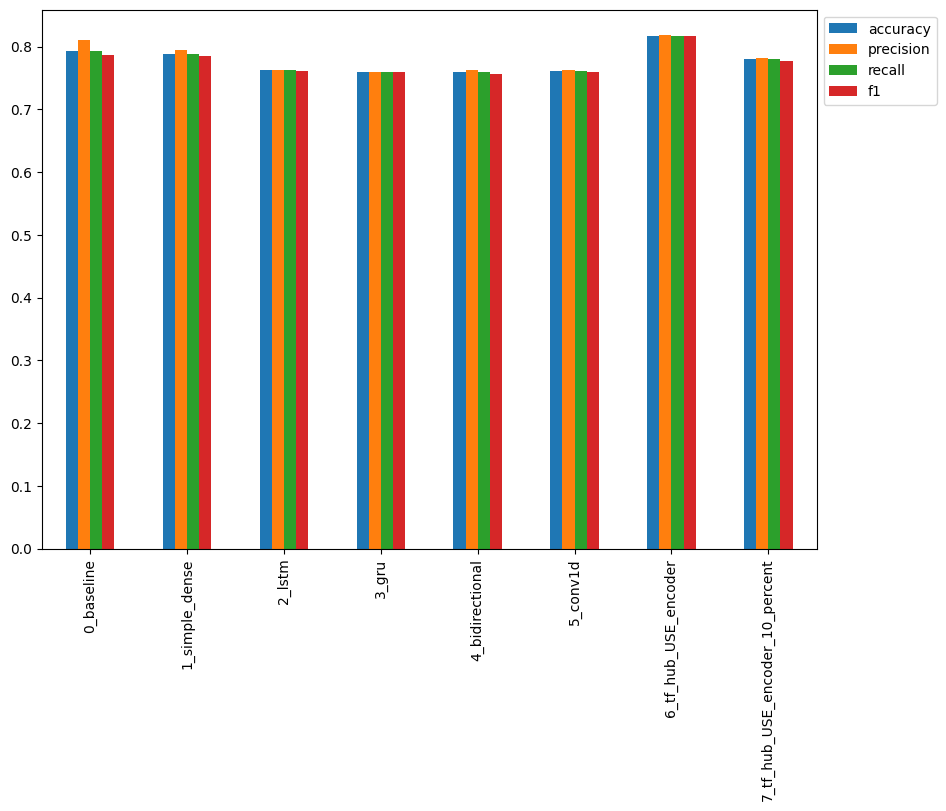

In [95]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

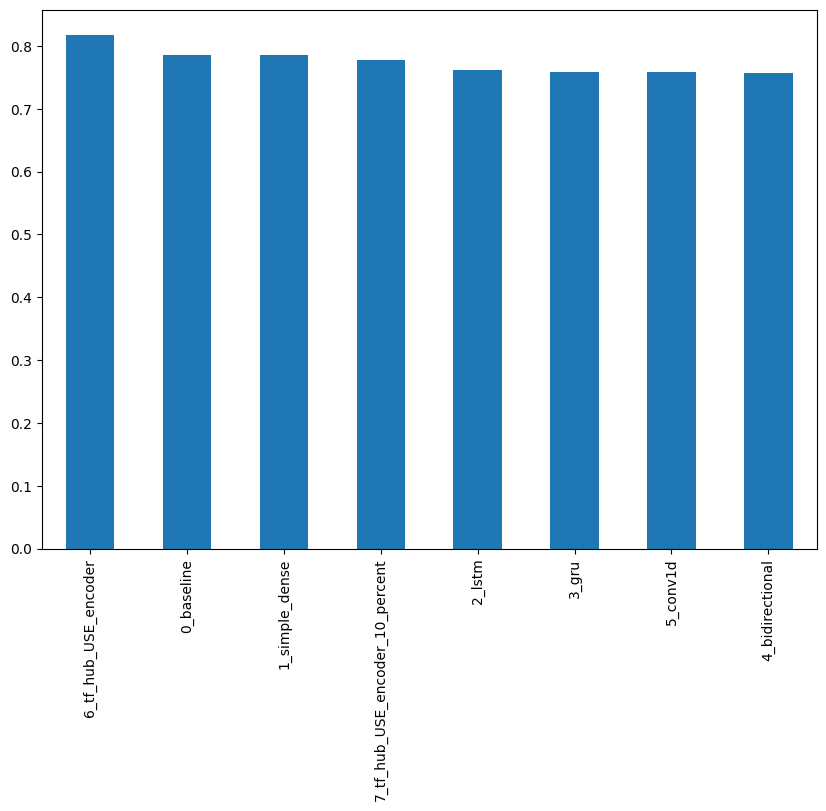

In [96]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Uploading model training logs to TensorBoard.dev

In [97]:
# View TensorBoard logs of all the modelling experiments
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets test classification dataset" \
  --one_shot # exit the uploader once ulpoading is finished

2023-08-18 22:34:50.125625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   RND-BBQ-BTR



New experiment created. View your TensorBoard at: https://tensorboard.dev/experi

In [98]:
# See previous TensorBoard dev experiments
!tensorboard dev list

2023-08-18 22:41:26.813323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/IYzW5xTMRS2LIQflg8btKQ/
	Name                 NLP Modelling Experiments
	Description          Comparing multiple different types of model architectures on the Kaggle Tweets test classification dataset
	Id                   IYzW5xTMRS2LIQflg8btKQ
	Created              2023-08-18 22:41:16 (12 seconds ago)
	Updated              2023-08-18 22:41:23 (5 seconds ago)
	Runs                 14
	Tags                 5
	Scalars              210
	Tensor bytes         0
	Binary object bytes  3572919
https://tensorboard.dev/experiment/nWYl3iRPQw6VCvVjZ3DbMA/
	Name                 NLP Modelling Experiments
	Description          Comparing multiple different types of model architectures on the Kaggle Tweets test classification dataset
	Id                   nWYl3iRPQw6VCvVjZ3DbMA
	Created              2023-08-18 18:39:21 (4 hours ago)
	Updated    

## Saving and loading a trained model

There are two main formats to save a model in TensorFlow:
1. HDF5 format
2. `SavedModel` format (this is default TensorFlow format)

In [99]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [100]:
# Load model with custom Hub Layer (required with HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [101]:
# Evaluate model in HDF5 format
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4260 - accuracy: 0.8176


[0.42598000168800354, 0.817585289478302]

In [102]:
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8179238046805183,
 'recall': 0.8175853018372703,
 'f1': 0.8168602489629228}

In [103]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [104]:
# Load in a model from SavedModel format
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [105]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 16ms/step - loss: 0.4260 - accuracy: 0.8176


[0.42597997188568115, 0.817585289478302]

## Finding the most wrong examples

* If best model still isn't perfect, what examples is it getting wrong?
* Of these wrong examples, which one is it getting *most* wrong?

In [106]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-08-18 22:42:11--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  40.8MB/s    in 16s     

2023-08-18 22:42:27 (56.8 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [107]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [108]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 1s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [109]:
# Create a DataFrame with validation sentences, validation labels and best performing model prediction labels + probs
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [110]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [111]:
most_wrong.tail() # false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


* `0` = not disaster
* `1` = disaster

In [112]:
# Check the false positive
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [113]:
# Check the false negative
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391850158572197
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.04

## Making predictions on the test dataset

In [114]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 45ms/step
Pred: 0, Prob: 0.3899674713611603
Text:
@CHold ironically RSL call their stadium the Riot

-----

1/1 [==============================] - 0s 58ms/step
Pred: 0, Prob: 0.06649921834468842
Text:
Mind salivation stretcher beds: KEGm

-----

1/1 [==============================] - 0s 42ms/step
Pred: 0, Prob: 0.3090685307979584
Text:
This is why you should be burned at the stake ! https://t.co/YpezipY2NY

-----

1/1 [==============================] - 0s 42ms/step
Pred: 0, Prob: 0.08198893815279007
Text:
One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1431

-----

1/1 [==============================] - 0s 44ms/step
Pred: 0, Prob: 0.18692512810230255
Text:
Media stocks are getting destroyed (DIS FOXA CMCSA SNI AMCX VIAB VIA TWX) http://t.co/dQd3YtaZfG

-----

1/1 [==============================] - 0s 56ms/step
Pred: 1, Prob: 0.9752106666564941
Text:
Turkish troops killed in Kurdish militant 'su

## The speed/performance tradeoff

In [115]:
# Making a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [116]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 11ms/step


(0.3549601119999579, 0.0004658269186351154)

In [117]:
# Calculate baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.022705227999949784, 2.9796887139041712e-05)

In [118]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-score')

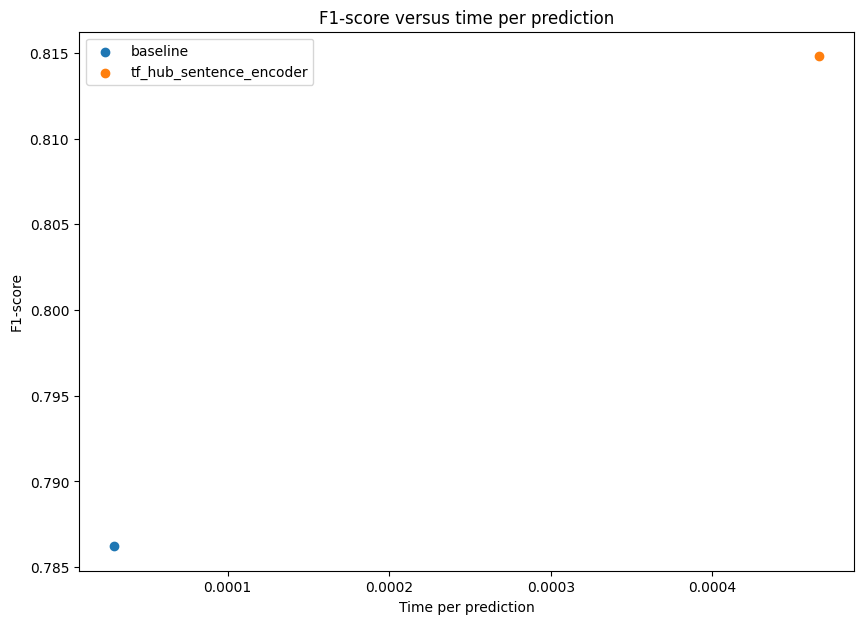

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")